# Visual Place Recognition - Homework

In [1]:
# Import
import numpy as np
import cv2
import os
import random

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import BallTree

In [3]:
# Setup paths
database_path = r'./NewCollege_dataset/database/'
query_path = r"./NewCollege_dataset/queries/"
num_of_imgs = 1

In [38]:
# Read query (target images)
query_imgs = []

query_paths = os.listdir(query_path)

# Sort
query_paths.sort()

for i in query_paths:
    # Read
    img = cv2.imread(os.path.join(query_path, i))
    # Store
    query_imgs.append(img[:, :, ::-1]) # BGR to RGB

query_paths

['0000.jpg',
 '0001.jpg',
 '0002.jpg',
 '0003.jpg',
 '0004.jpg',
 '0005.jpg',
 '0006.jpg',
 '0007.jpg']

In [5]:
# Read a few random images as well
sampled_imgs = []
num_samples = len(query_imgs)
sample_paths = random.sample(os.listdir(database_path), num_samples)

for i in sample_paths:
    # Read
    img = cv2.imread(os.path.join(database_path, i))
    # Store
    sampled_imgs.append(img[:, :, ::-1]) # BGR to RGB

In [6]:
# Create SIFT feature extractor
sift = cv2.SIFT_create()

In [7]:
# Use slim = True for lower compute / memory usage
def extract_aggregate_features(extractor, folder_path, slim = False, periodicity = 5):
    all_descriptors = list()
    # database_features = dict()

    # Determine images to read
    cadence = 1 if not slim else periodicity
    img_paths = os.listdir(folder_path)[::cadence]

    # Read and extract features
    for img_name in tqdm(img_paths):
        # Read
        img = cv2.imread(folder_path + img_name)
        # Extract features
        kp, des = extractor.detectAndCompute(img, None)
        # Store
        all_descriptors.extend(des)
        # database_features[img_name] = des
        
    all_descriptors = np.array(all_descriptors)
    return all_descriptors, img_paths

In [8]:
# Assemble database and extract features
slim = False
database_entries, img_paths = extract_aggregate_features(sift, database_path, slim = slim)

100%|██████████| 2146/2146 [00:17<00:00, 119.22it/s]


In [9]:
# Clustering the entire bag of descriptor
codebook = KMeans(n_clusters = 64, init = 'k-means++', n_init = 10, verbose = 1).fit(database_entries)

Initialization complete
Iteration 0, inertia 43826487296.0
Iteration 1, inertia 30166071296.0
Iteration 2, inertia 29566230528.0
Iteration 3, inertia 29325899776.0
Iteration 4, inertia 29190461440.0
Iteration 5, inertia 29098686464.0
Iteration 6, inertia 29029314560.0
Iteration 7, inertia 28972457984.0
Iteration 8, inertia 28923834368.0
Iteration 9, inertia 28882143232.0
Iteration 10, inertia 28845955072.0
Iteration 11, inertia 28815648768.0
Iteration 12, inertia 28790208512.0
Iteration 13, inertia 28769212416.0
Iteration 14, inertia 28751396864.0
Iteration 15, inertia 28737126400.0
Iteration 16, inertia 28725248000.0
Iteration 17, inertia 28714876928.0
Iteration 18, inertia 28705951744.0
Iteration 19, inertia 28697970688.0
Iteration 20, inertia 28691488768.0
Iteration 21, inertia 28685606912.0
Iteration 22, inertia 28680900608.0
Iteration 23, inertia 28676261888.0
Iteration 24, inertia 28671979520.0
Iteration 25, inertia 28667752448.0
Iteration 26, inertia 28664125440.0
Iteration 27, 

In [10]:
# VLAD
def get_VLAD(X, codebook):
    predictedLabels = codebook.predict(X)
    centroids = codebook.cluster_centers_
    labels = codebook.labels_
    k = codebook.n_clusters

    m, d = X.shape
    VLAD_features = np.zeros((k, d))

    # Computing the residuals
    for i in range(k):
        # Check if the cluster is empty
        if np.sum(predictedLabels == i) > 0:
            VLAD_features[i] = np.sum(X[predictedLabels == i, :] - centroids[i], axis = 0)
    
    VLAD_features = VLAD_features.flatten()
    # Power normalization
    VLAD_features = np.sign(VLAD_features) * np.sqrt(np.abs(VLAD_features))

    # L2 normalization
    VLAD_features = VLAD_features / np.linalg.norm(VLAD_features)
    return VLAD_features


In [11]:
# Initialize and build VLAD collection
database_VLAD = list()
database_name = list()

period = 1 if not slim else 5

for img_name in tqdm(img_paths):
# for img_name in tqdm(img_paths[::period]):
    # Read
    img = cv2.imread(database_path + img_name)
    # Extract features
    kp, des = sift.detectAndCompute(img, None)
    # Get VLAD
    VLAD = get_VLAD(des, codebook)
    # Store
    database_VLAD.append(VLAD)
    database_name.append(img_name)

database_VLAD = np.array(database_VLAD)

100%|██████████| 2146/2146 [00:24<00:00, 88.11it/s] 


In [12]:
# Query model
tree = BallTree(database_VLAD, leaf_size = 60)

In [30]:
# Fetch
value_list = list()

sorted_query_path = os.listdir(query_path)
sorted_query_path.sort()

for img_name in sorted_query_path:
    query = cv2.imread(query_path + img_name)
    q_kp, q_des = sift.detectAndCompute(query, None)
    q_VLAD = get_VLAD(q_des, codebook).reshape(1, -1)

    # Only want the cloest one
    dist, index = tree.query(q_VLAD, k = num_of_imgs)
    print(database_name[index[0][0]], "dist:", dist[0][0])

    # Index is an array of array of 1
    value_name = database_name[index[0][0]]
    value_list.append(value_name)

0003.jpg dist: 0.0
0238.jpg dist: 0.0
0402.jpg dist: 0.0
0462.jpg dist: 0.0
0642.jpg dist: 0.0
0724.jpg dist: 0.0
0783.jpg dist: 0.0
1149.jpg dist: 0.0


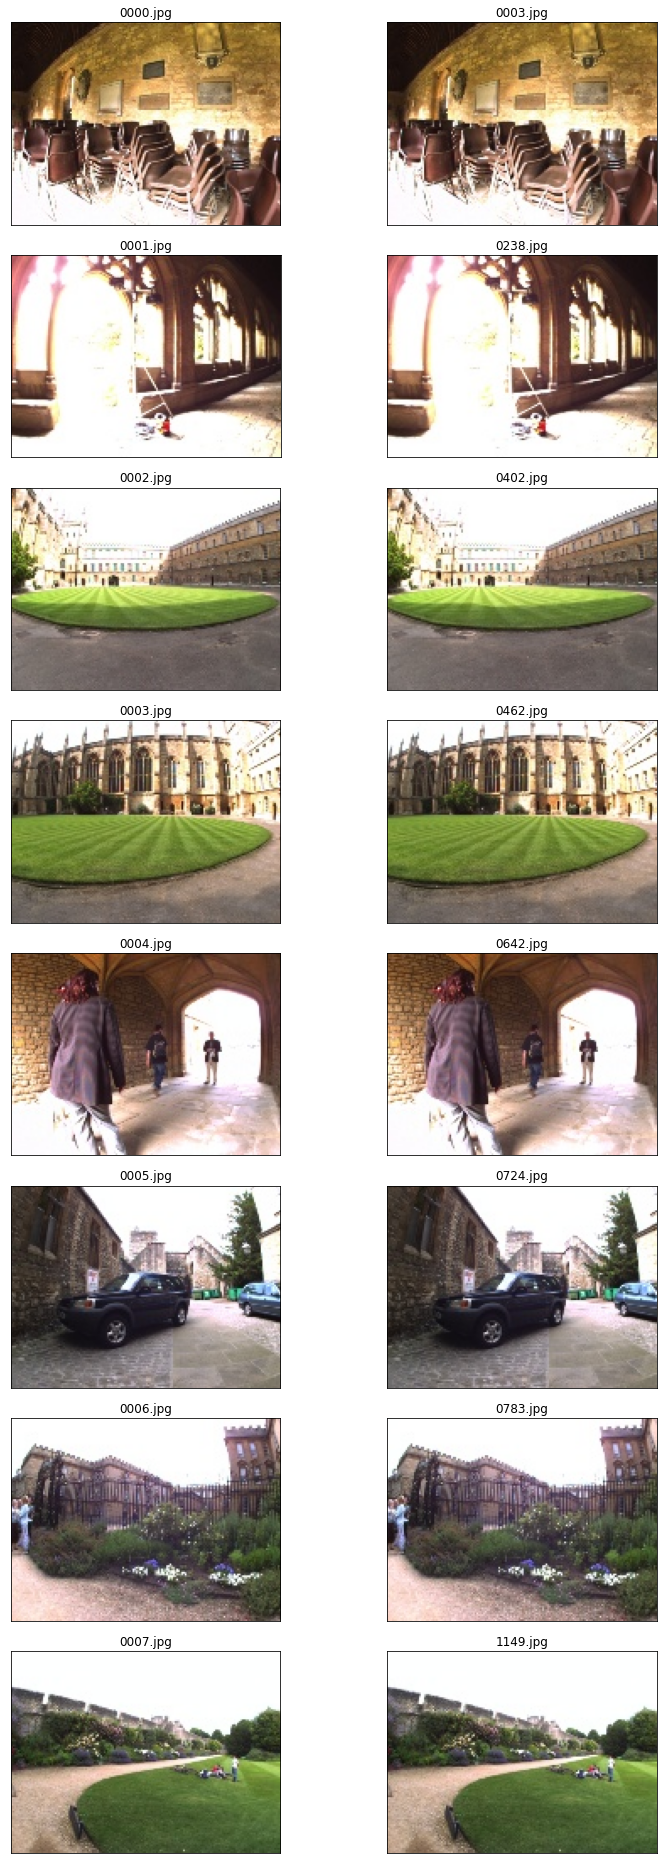

In [39]:
recovered_imgs = [cv2.imread(os.path.join(database_path, i))[:, :, ::-1] for i in value_list]

# Plot
fig,axs = plt.subplots(num_samples,2,figsize=(12,26))

for idx,(i,j) in enumerate(zip(query_imgs, recovered_imgs)):
    
    #Plot
    axs[idx,0].imshow(i)
    axs[idx,1].imshow(j)
    
    #Set title to ref img names
    axs[idx,0].title.set_text(query_paths[idx])
    axs[idx,1].title.set_text(value_list[idx])
    
    #Tidy things up
    axs[idx,0].set_yticks([])
    axs[idx,0].set_xticks([])
    axs[idx,1].set_yticks([])
    axs[idx,1].set_xticks([])
    
fig.tight_layout()